In [1]:
import sys,os
sys.path.insert(0, os.getcwd())

In [2]:
# silence all warnings
import warnings
warnings.filterwarnings("ignore")

# Evaluating resource allocation models for assembly HPC jobs

Accurately predicting resource use is essential in shared HPC systems. When memory estimates are off, throughput of a pipeline is limited or results in waste resources. Choosing the right model requires evaluation methods that reflect how systems actually run.

From a user’s view, a failed job means lost time and job caring. From an HPC administrator’s view, it means resource duplication when the system retries. Both translate into wasted compute.

In this analysis, we tested several models and evaluation metrics to understand which approach best supports real-world HPC workloads.

---

## Standard metrics tell only part of the story

We started with the usual indicators — MAE, RMSE, and R² — and included a safety/efficiency trade-off metric.

At first, the Random Forest model looked best. It achieved the lowest error and offered a good balance between under- and over-prediction.

In [3]:
## From kmer frequency
import argparse
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_predict

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

sns.set(style="whitegrid")


def load_stats(stats_path: Path) -> pd.DataFrame:
    # try load with first column as index (common when saving DataFrame.to_csv())
    df = pd.read_csv(stats_path, index_col=0)
    # ensure numeric columns only (drop metrics that are non-numeric)
    df = df.apply(pd.to_numeric, errors="coerce")
    return df


def load_metadata(meta_path: Path) -> pd.DataFrame:
    df = pd.read_csv(meta_path)
    # try common names
    if "srr_id" in df.columns and "peak_mem_in_gbs" in df.columns:
        df2 = df.set_index("srr_id")[["peak_mem_in_gbs"]]
        return df2

    # fallback: try to find the best column names
    candidates = [c for c in df.columns if "srr" in c.lower() or "run" in c.lower()]
    mem_cols = [c for c in df.columns if "mem" in c.lower() or "peak" in c.lower()]
    if candidates and mem_cols:
        idx_col = candidates[0]
        mem_col = mem_cols[0]
        return df.set_index(idx_col)[[mem_col]].rename(columns={mem_col: "peak_mem_in_gbs"})

    raise ValueError("Could not find 'srr_id' and 'peak_mem_in_gbs' columns in metadata."
                     " Please provide a metadata CSV with these columns.")


def compute_tradeoff(y_true: np.ndarray, y_pred_base: np.ndarray, adjustment_steps: np.ndarray):
    underpred_percent_list = []
    excess_memory_list = []
    n_samples = len(y_true)

    for adj in adjustment_steps:
        y_pred_adj = y_pred_base + adj
        under_pred_mask = y_pred_adj < y_true
        under_pred_count = np.sum(under_pred_mask)
        under_pred_percent = (under_pred_count / n_samples) * 100

        # for samples where prediction >= true, compute excess memory
        excess_memory = y_pred_adj[~under_pred_mask] - y_true[~under_pred_mask]
        total_excess_memory = np.sum(excess_memory)

        underpred_percent_list.append(under_pred_percent)
        excess_memory_list.append(total_excess_memory)

    return np.array(underpred_percent_list), np.array(excess_memory_list)

p = argparse.ArgumentParser()

p.add_argument("--output", default="tradeoff_models.png", help="Output plot file (PNG)")
p.add_argument("--adjust-min", type=float, default=-100.0, help="Min adjustment (GB)")
p.add_argument("--adjust-max", type=float, default=100.0, help="Max adjustment (GB)")
p.add_argument("--adjust-step", type=float, default=5.0, help="Adjustment step (GB)")
args = p.parse_args([])



In [4]:
import sys,os
sys.path.append(str(Path(os.getcwd()).resolve().parent))

from training.gaussian_process import *

In [5]:
stats_file = "../../Kmer-Memory-Predict/updated_mgnify_assemblies_stats_v3.15.3_metaspades_kmer_stats.csv"
y_file = "../../Kmer-Memory-Predict/input/updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset.csv"

df = load_your_data(stats_file, y_file)
df = df[df["peak_mem_in_gbs"] <= df["peak_mem_in_gbs"].quantile(0.95)]
df = df[df["file_size"] <= df["file_size"].quantile(0.95)]

stats = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

features_all = stats.columns.tolist()

In [ ]:
### Our current allocation method, add it for comparison
biome_heuristic_table = pd.read_csv("./data/biome_assembler_heurs.tsv",sep="\t")
"""
memory_gb	process	assembler_name	biome_name	biome_lineage
80	ASSEM	flye	root	root
80	ASSEM	megahit	root	root
"""

def our_allocation_method(
        biome_lineage: str,
        process: str = "ASSEM",
        assembler_name: str = "metaspades",
) -> float:
        """
        finds the rows in biome_heuristic_table that match the process and assembler_name params,
        fot biome_lineage finds the most specific match (longest string match)
        returns the memory_gb value for that row
        if no match found, returns 80.0 (default)
        """
        biome_lineage = biome_lineage.lower().replace("-","_").replace(":",".").replace(" ","_")
        new_df = biome_heuristic_table[
                (biome_heuristic_table["process"] == process) &
                (biome_heuristic_table["assembler_name"] == assembler_name)
        ].copy()
        if new_df.empty:
                return 80.0
        # find most specific match for biome_lineage
        new_df["lineage_length"] = new_df["biome_lineage"].apply(len)

        new_df = new_df[new_df["biome_lineage"].apply(lambda x: biome_lineage.startswith(x))]
        if new_df.empty:
                return 80.0
        new_df = new_df.sort_values(by="lineage_length", ascending=False)
        return float(new_df.iloc[0]["memory_gb"])



In [ ]:
quant_results = {}


## find the lineage of each sample in traing dataset

mgnify_dataset = pd.read_csv("../../Kmer-Memory-Predict/input/mgnify_assemblies_stats.csv")
link_df = pd.read_csv("../../Kmer-Memory-Predict/input/updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset.csv")
err_to_erz = dict(zip(link_df["srr_id"], link_df["primary_accession"]))
erz_to_biome = dict(zip(mgnify_dataset["primary_accession"], mgnify_dataset["lineage"]))
training_df_biomes = [erz_to_biome.get(err_to_erz.get(srr,""),"root") for srr in df.index]
heuristics_memory_allocation = [our_allocation_method(biome_lineage=bl) for bl in training_df_biomes]
quant_results[("Heuristic","default")] = np.array(heuristics_memory_allocation)

In [18]:
## Train a model that takes into account the biome
trimmed_biomes = [":".join(x.split(":")[:3]) if "Engineered" in x else ":".join(x.split(":")[:4]) for x in training_df_biomes]
# encode biome as categorical variable and join with stats
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
biome_ohe = ohe.fit_transform(np.array(trimmed_biomes).reshape(-1,1))
biome_ohe_df = pd.DataFrame(biome_ohe, index=df.index, columns=[f"biome_{c}" for c in ohe.categories_[0]])
stats_biome = pd.concat([stats, biome_ohe_df], axis=1)
df_biome = pd.concat([df, biome_ohe_df], axis=1)
# stats_biome


In [ ]:

# build model list
models = [
    ("Random Forest (All)", features_all, RandomForestRegressor(random_state=42)),
    # ("File size (Linear)", ["file_size"], LinearRegression()),
]


cv = KFold(n_splits=5, shuffle=True, random_state=42)

# quant_results = {}
quantiles = [0.9, 0.99]

# iterate through folds
for train_idx, test_idx in cv.split(stats, y):
    x_train,y_train = stats.iloc[train_idx], y[train_idx]
    x_test,y_test = stats.iloc[test_idx],y[test_idx]
    for title, feat_list, _base_model in models:
    # title, feat_list, model = models[0]
        _base_model.fit(x_train[feat_list],y_train)
        preds = _base_model.predict(x_test[feat_list])
        quant_results.setdefault((title,"default"), np.empty_like(y))[test_idx]  = preds
        # 
        _base_model.fit(stats_biome.iloc[train_idx],y_train)
        preds = _base_model.predict(stats_biome.iloc[test_idx])
        quant_results.setdefault((title,"+ Biome"), np.empty_like(y))[test_idx]  = preds

    ## BAYES
    model = train_and_save(df.iloc[train_idx], out_path=None, log_target=False)
    model_biome = train_and_save(df_biome.iloc[train_idx], out_path=None, log_target=False)

    # 3) Evaluate on validation split
    X_val = df.iloc[test_idx].drop(columns=[TARGET_COL])
    Xbiome_val = df_biome.iloc[test_idx].drop(columns=[TARGET_COL])
    y_val = df.iloc[test_idx][TARGET_COL].to_numpy(float)

    for _q in quantiles:
        _y_q = model.predict_quantile(X_val, q=_q)
        quant_results.setdefault(("Gaussian Processes",_q), np.empty_like(y))[test_idx]  = _y_q
        _y_q = model_biome.predict_quantile(Xbiome_val, q=_q)
        quant_results.setdefault(("Gaussian Processes biome",_q), np.empty_like(y))[test_idx]  = _y_q
        

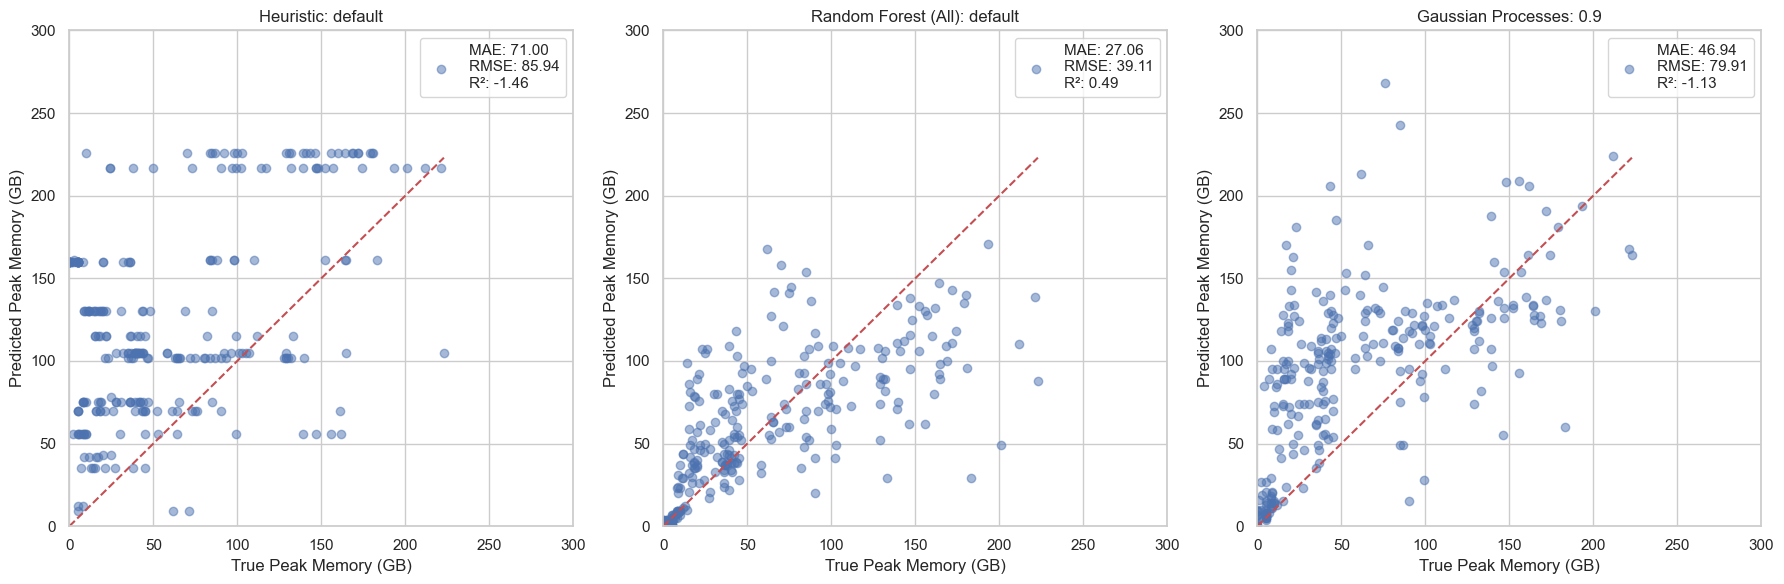

In [68]:
# 3 subplots with scatterplots of predictions vs true. where true = list(y) and pred = quant_results[keys]. The keys I want are [("Random Forest (All)","default"),("File size (Linear)","default"),("Gaussian Processes",0.9999)] 
# - draw diagonal, 
# - also calculate MAE, RMSE, and R² (show in legend)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
keys = [
    ("Heuristic","default"),
    # ("File size (Linear)","default"),
    ("Random Forest (All)","default"),
    ("Gaussian Processes",0.9)
    ]
fig, axes = plt.subplots(1, len(keys), figsize=(6*len(keys), 6))
for ax, key in zip(axes, keys):
    preds = quant_results[key]
    ax.scatter(y, preds, alpha=0.5)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    ax.set_title(f"{key[0]}: {key[1]}")
    ax.set_xlabel("True Peak Memory (GB)")
    ax.set_ylabel("Predicted Peak Memory (GB)")
    mae = mean_absolute_error(y, preds)
    rmse = root_mean_squared_error(y, preds)
    r2 = r2_score(y, preds)
    ax.legend([f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}"])
    # set limits
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 300)
plt.tight_layout()

In [69]:
from importlib import reload
import evaluate_memory_allocation_methods
reload(evaluate_memory_allocation_methods)
from evaluate_memory_allocation_methods import HPCMemoryEvaluator, WeightingConfig

In [70]:
# import JobCost from evaluation metrics in a way the if code changed after initial import ir reimports

from importlib import reload
import evaluation_metrics
reload(evaluation_metrics)
from evaluation_metrics import JobCost,failure_rate,overallocation,binned_metrics


In [71]:
# from ..evaluation.memeory_prediction import *


li = []

adjustment_steps = np.arange(args.adjust_min, args.adjust_max + 0.0001, args.adjust_step)



# keys = [("Random Forest (All)","default"),("File size (Linear)","default")]
for (key,val) in keys:
    _y_pred = quant_results[(key,val)]

    for adj in adjustment_steps:
        _y_pred_adj = _y_pred + adj
        
        # stats from evaluation module
        failure_rate_val, overallocation_val = failure_rate(y, _y_pred_adj), overallocation(y, _y_pred_adj)
        
        # total exess
        under_pred_mask = _y_pred_adj < y
        under_pred_count = np.sum(under_pred_mask)
        under_pred_percent = (under_pred_count / len(y)) * 100
        
        excess_memory = _y_pred_adj[~under_pred_mask] - y[~under_pred_mask]
        total_excess_memory = np.sum(excess_memory)

        li.append((f"{key}_{round(adj,3)}", key, str(round(adj,3)), failure_rate_val, overallocation_val, under_pred_percent, total_excess_memory))
    
for (method,quant),_y_pred in quant_results.items():
    if method is not "Gaussian Processes":
        continue
    
    # stats from evaluation module
    failure_rate_val, overallocation_val = failure_rate(y, _y_pred), overallocation(y, _y_pred)

    # total exess
    under_pred_mask = _y_pred < y
    under_pred_count = np.sum(under_pred_mask)
    under_pred_percent = (under_pred_count / len(y)) * 100
    
    excess_memory = _y_pred[~under_pred_mask] - y[~under_pred_mask]
    total_excess_memory = np.sum(excess_memory)

    li.append((f"{method}_{quant}", method, str(quant), failure_rate_val, overallocation_val,under_pred_percent, total_excess_memory))


df_with_stats = pd.DataFrame(li, columns=['model_param', 'model', 'param', 'failure_rate', 'overallocation', 'underpred_percent', 'total_excess_memory'])



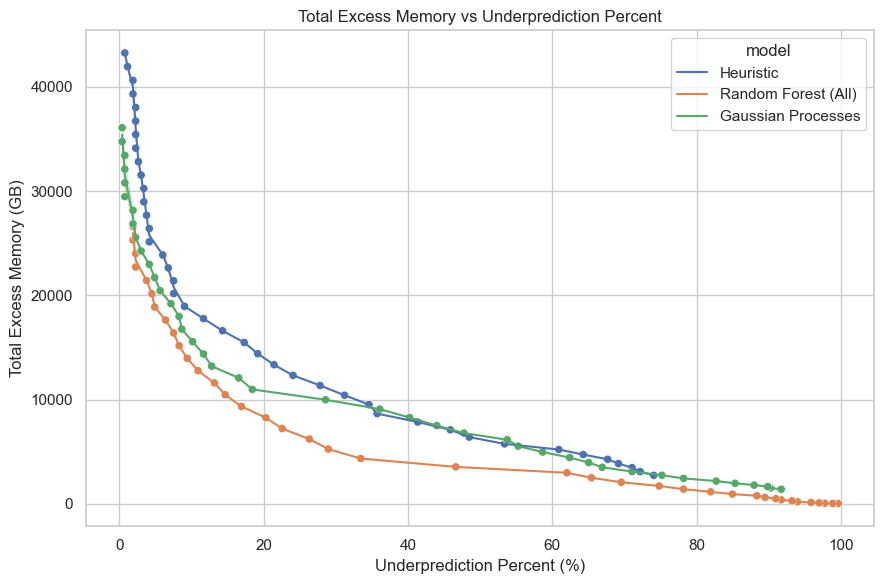

In [72]:
# lineplot of underpred percent vs total excess memory
# show with points for each model
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
# sns.lineplot(data=df_with_stats, y='failure_rate', x='overallocation', hue='model', ax=axes[1])
sns.lineplot(data=df_with_stats, x='underpred_percent', y='total_excess_memory', hue='model', ax=axes)
sns.scatterplot(data=df_with_stats, x='underpred_percent', y='total_excess_memory', hue='model', ax=axes,legend=False)
# axes[1].set_title('Failure Rate vs Overallocation')
# axes[1].set_xlabel('Overallocation')
# axes[1].set_ylabel('Failure Rate')
axes.set_title('Total Excess Memory vs Underprediction Percent')
axes.set_ylabel('Total Excess Memory (GB)')
axes.set_xlabel('Underprediction Percent (%)')

plt.tight_layout()


---

## Real workloads look different from the evaluation set

When we compared the memory usage patterns of real jobs with our evaluation dataset, we saw a major mismatch.

Production jobs were smaller and more varied, while the evaluation data contained many large jobs.

This difference matters. Standard metrics assume both sets are similar. In reality, that assumption biases results toward models that perform well on large jobs — even if they fail more often in real operations.

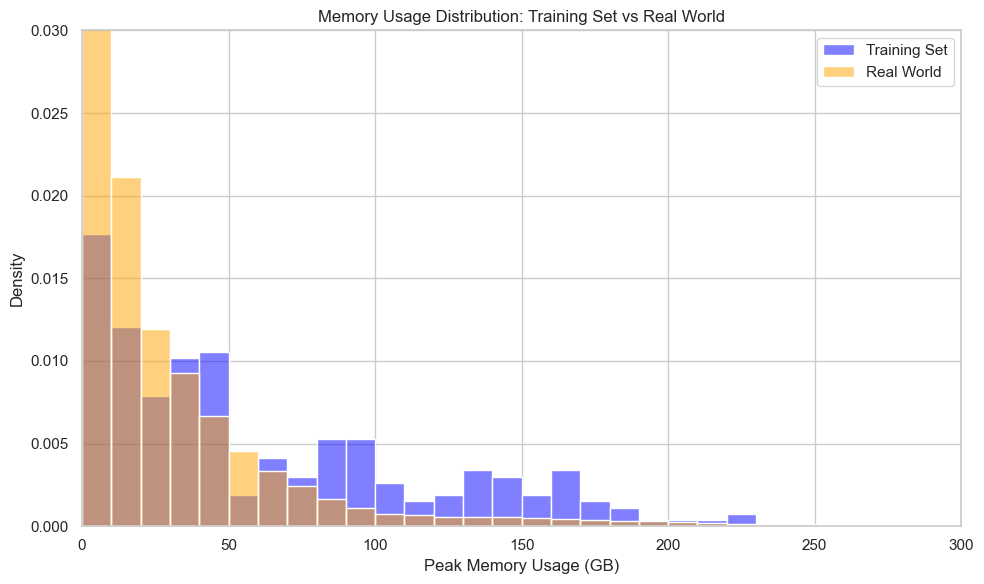

In [25]:
mgnify_dataset = pd.read_csv("../../Kmer-Memory-Predict/input/mgnify_assemblies_stats.csv")

train_set_memory_usage = df["peak_mem_in_gbs"]
real_world_memory_usage = mgnify_dataset["peak_mem_in_gbs"]

# plot in one histogram both distributions. bin size 10GB, x limit 0-300GB
# use seaborn for better aesthetics
plt.figure(figsize=(10,6))
sns.histplot(train_set_memory_usage, bins=np.arange(0, 310, 10), color='blue', label='Training Set', kde=False, stat='density', alpha=0.5)
sns.histplot(real_world_memory_usage, bins=np.arange(0, 310, 10), color='orange', label='Real World', kde=False, stat='density', alpha=0.5)
plt.xlim(0, 300)
plt.ylim(0, 0.03)
plt.xlabel('Peak Memory Usage (GB)')
plt.ylabel('Density')
plt.title('Memory Usage Distribution: Training Set vs Real World')
plt.legend()
plt.tight_layout()
plt.show()

## Plots showing bins of mem vs underprediction failure rate

In [40]:
# Make plot of 
n_bins=5
mem_bined_stats = []
for key in keys:
    method,param = key
    _y_pred = quant_results[(method,param)]

    if "Random" in str(method):
        adjustment_steps = np.arange(0, 150, 50)
        for step in adjustment_steps:
            _y_pred_adj = _y_pred + step
            bin_centers, failure_rates, overallocations, bin_counts = binned_metrics(y.to_numpy(), _y_pred_adj, n_bins=n_bins)
            for bc,fr,orc,bcnt in zip(bin_centers, failure_rates, overallocations, bin_counts):
                mem_bined_stats.append((f"{method}_{round(step,3)}",f"{method}",f"{round(step,3)}", bc, fr, orc, bcnt))
    # elif "corre" in str(title) or "0.995" not in str(title) or "0.9999" not in str(title):
        # continue
    # elif str(param) in ["0.9999"]: 
    else:
        bin_centers, failure_rates, overallocations, bin_counts = binned_metrics(y.to_numpy(), _y_pred, n_bins=n_bins)
        param = "default"
        for bc,fr,orc,bcnt in zip(bin_centers, failure_rates, overallocations, bin_counts):
            mem_bined_stats.append((f"{method}_{param}",f"{method}", f"{param}", bc, fr, orc, bcnt))
            
mem_bined_stats_df = pd.DataFrame(mem_bined_stats, columns=['model_param',"model","param", 'bin_center', 'failure_rate', 'overallocation', 'bin_count'])



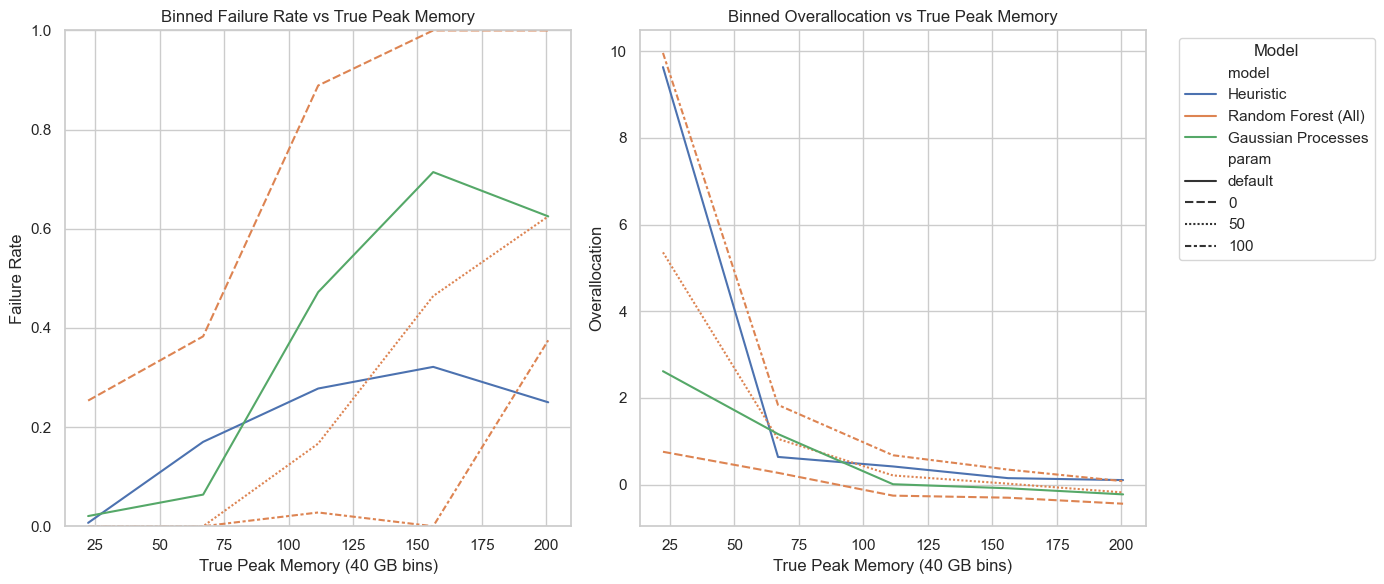

In [41]:

# 2 sidebyside subplots of failure rate and overallocation vs bin_center
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
sns.lineplot(data=mem_bined_stats_df, x='bin_center', y='failure_rate', hue='model',style="param", ax=ax1)
ax1.set_title('Binned Failure Rate vs True Peak Memory')
ax1.set_xlabel('True Peak Memory (40 GB bins)')
ax1.set_ylabel('Failure Rate')
ax1.set_ylim(0, 1)
# hide legend
ax1.legend_.remove()
# ax1.legend(None)

sns.lineplot(data=mem_bined_stats_df, x='bin_center', y='overallocation', hue='model',style="param", ax=ax2)
ax2.set_title('Binned Overallocation vs True Peak Memory')
ax2.set_xlabel('True Peak Memory (40 GB bins)')
ax2.set_ylabel('Overallocation')
ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig("binned_failure_overallocation.png", dpi=150)

Further analysis showed that all models struggled with high-memory jobs.

Underestimation led to failed jobs, while overestimation wasted memory on smaller ones.

---

## Rethinking what “good” looks like

A better evaluation should reflect the true cost per job, not just error magnitude between the prediction and the true peak memory.

That cost includes wasted allocations, retry attempts, and the duaration of asked allocations.

Considering these factors, we defined a cost function:
$$
C(y; a_0) = 
\underbrace{\sum_{r=0}^{R-1} C_{\text{fail}}(y, a_r)}_{\text{cost of retries}} 
+ 
\underbrace{C_{\text{over}}(y, a_R)}_{\text{waste on the successful attempt}}
$$
Where:
\[
\begin{aligned}
y &:\ \text{true peak memory use} \\
a_0 &:\ \text{initial memory allocation} \\
a_r &:\ \text{allocation on retry } r \\
R &:\ \text{total number of retries until success} \\
a_R &:\ \text{allocation on successful attempt} \\
C_{\text{fail}}(y, a_r) &:\ \text{cost incurred when a job fails due to under-allocation} \\
C_{\text{over}}(y, a_R) &:\ \text{cost incurred from over-allocation on the successful attempt}
\end{aligned}
\]

Using this function we can simulate the total cost of running jobs under different prediction models and allocation strategies.

For example, a model that underpredicts slightly might cause multiple retries — each consuming more total resources than a single, slightly overpredicted allocation.

**High accuracy of peak memory prediction doesn’t guarantee lower waste**.

We visualise this effect when a job’s true memory use is 120 GB, different starting allocations lead to very different total resource costs. Small prediction errors can multiply into large operational waste.

__Figure:__ Illustration of job memory usage over time.  
Each bar shows a single job attempt, where **height** represents memory usage and **width** represents wall time.  
The **total shaded area** corresponds to the overall resource cost until the job completes successfully. **Dark blue** indicates true memory used, while **light blue** shows wasted allocation.


In [42]:
# Example usage

# dummy_policy = lambda R, a0: a0*2**(R)
dummy_policy = lambda R, a0: a0*(R+1)
y_true = 120.0  # True peak memory in GB
true_wall_time = 50.0  # True wall time in hours

# list of simulated initial allocation
allocations = [25.0, 110.0, 160.0]


In [36]:
# import JobCost from evaluation metrics in a way the if code changed after initial import ir reimports

from importlib import reload
import evaluation_metrics
reload(evaluation_metrics)
from evaluation_metrics import JobCost


/tmp/ipykernel_1226469/3462535538.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 1, 0.98))


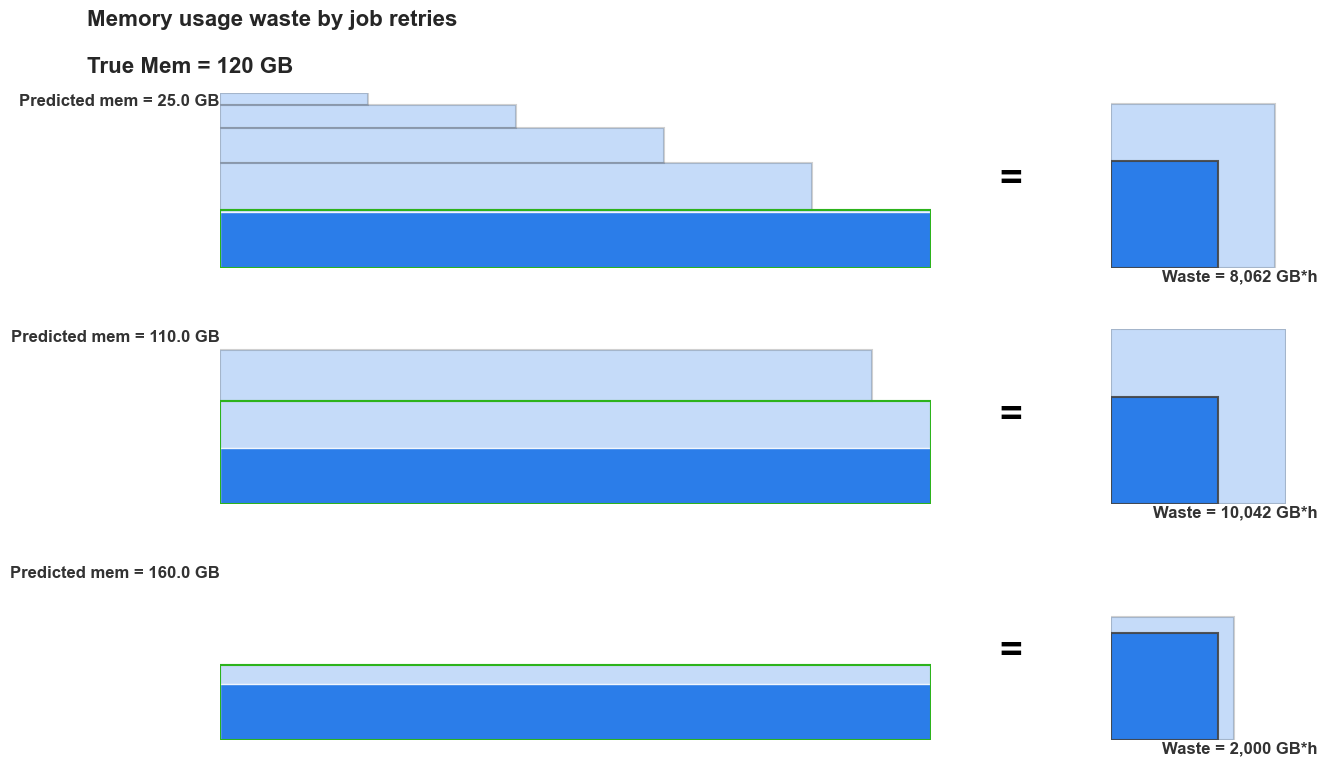

In [37]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def kill_axes(ax):
    ax.set_xticks([]); ax.set_yticks([])
    for side in ("left","right","top","bottom"):
        ax.spines[side].set_visible(False)

# ---------- gather results + global scales ----------
runs = []
max_job_width = 0.0
max_total_height = 0.0
max_outer_side = 0.0
inner_side = np.sqrt(y_true * true_wall_time)

for a0 in allocations:
    result = JobCost.job_cost(y_true, true_wall_time, dummy_policy, a0)
    runs.append((a0, result))
    max_job_width = max(max_job_width,
                        max([w for w,_ in result["failed_alloc_time"]] + [true_wall_time]))
    total_h = sum(h for _,h in result["failed_alloc_time"]) + result["a_R"]
    max_total_height = max(max_total_height, total_h)
    max_outer_side = max(max_outer_side, np.sqrt(result["total_mem_rate"]))

# ---------- layout ----------
n = len(runs)
fig = plt.figure(figsize=(14, 2.8 * n))
gs = fig.add_gridspec(nrows=n, ncols=3, width_ratios=[4.0, 0.35, 1.2], wspace=0.15, hspace=0.35)

for i, (a0, result) in enumerate(runs):
    axL = fig.add_subplot(gs[i, 0])  # jobs
    axE = fig.add_subplot(gs[i, 1])  # "="
    axR = fig.add_subplot(gs[i, 2])  # squares

    # ----- left: stack jobs top -> bottom; green on bottom -----
    total_h = sum(h for _,h in result["failed_alloc_time"]) + result["a_R"]
    y_top = total_h
    # failed jobs: first one ends up at the top
    for w, h in result["failed_alloc_time"]:
        y_top -= h
        axL.add_patch(Rectangle((0, y_top), w, h,
                                facecolor="#1A73E8", alpha=0.25, edgecolor="#444444",
                                linewidth=1.5, antialiased=True))
    
    # final job in red
    
    # final green job at y=0 (bottom)

    axL.add_patch(Rectangle((0, 0), true_wall_time, result["a_R"],
                        facecolor="#1A73E8", alpha=0.25, edgecolor="#2DB31C",
                            linewidth=1.5, antialiased=True))
    
    axL.add_patch(Rectangle((0, 0), true_wall_time, y_true,
                        facecolor="#1A73E8", alpha=0.9, 
                        linewidth=None, antialiased=True))

    axL.add_patch(Rectangle((0, 0), true_wall_time, result["a_R"],
                        facecolor="none", edgecolor="#2DB31C",
                            linewidth=1.5, antialiased=True))
    
    axL.set_xlim(0, max_job_width)
    axL.set_ylim(0, max_total_height)
    kill_axes(axL)  # <- removes spines so no line cuts through bars
    axL.text(0, max_total_height, f"Predicted mem = {a0:.1f} GB",
             ha="right", va="top", fontsize=12, fontweight="bold", color="#333")

    # ----- middle: equal sign (aligned across rows) -----
    kill_axes(axE)
    axE.text(0.5, 0.5, "=", ha="center", va="center",
             fontsize=28, fontweight="bold", color="black")

    # ----- right: blue squares (true squares) -----
    outer_side = np.sqrt(result["total_mem_rate"])
    axR.add_patch(Rectangle((0, 0), outer_side, outer_side,
                            facecolor="#1A73E8", alpha=0.25,
                            edgecolor="#444444", linewidth=1.5))
    axR.add_patch(Rectangle((0, 0), inner_side, inner_side,
                            facecolor="#1A73E8", alpha=0.90,
                            edgecolor="#444444", linewidth=1.5))
    axR.set_xlim(0, max_outer_side); axR.set_ylim(0, max_outer_side)
    
    axR.text(150, 0, f"Waste = {result['total_waste_rate']:,.0f} GB*h",
             ha="right", va="top", fontsize=12, fontweight="bold", color="#333")
    axR.set_aspect('equal', adjustable='box')
    kill_axes(axR)

fig.suptitle(f"Memory usage waste by job retries\n\nTrue Mem = {y_true:.0f} GB", fontsize=16, fontweight="bold",
             x=0.03, ha="left")
plt.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

---

## What the results show

When we compared all models using cost-based metrics—total memory usage waste, total wall time, and failure rate —based on real production distribution, the results changed.

In [60]:
from importlib import reload
import evaluate_memory_allocation_methods
reload(evaluate_memory_allocation_methods)
from evaluate_memory_allocation_methods import HPCMemoryEvaluator, WeightingConfig

In [ ]:
# # from evaluate_memory_allocation_methods import (
# #     HPCMemoryEvaluator, WeightingConfig, synth_data,
# #     default_total_waste, default_total_wall_time,
# # )
# from evaluation_metrics import JobCost

# get true wall time
erz_to_wall_time = dict(zip(mgnify_dataset["primary_accession"], mgnify_dataset["wall_clock_seconds"]))
training_df_wall_time = (np.array([erz_to_wall_time.get(err_to_erz.get(srr,"")) for srr in df.index]) /60)/60 # in hours


# 1) Provide data
real_logs_peak_memory = mgnify_dataset["peak_mem_in_gbs"].to_numpy()               
sample_true = y.to_numpy()            
base_wall_time = training_df_wall_time
retry_policy = lambda R, a0: (R+1)*a0 # this is our current policy

predictors: Dict[str, np.ndarray] = {f"{x[0]} {x[1]}":quant_results[x] for x in [
    ("Heuristic","default"),
    ("Random Forest (All)","default"),
    ("Gaussian Processes biome",0.9),
    ]}  
predictors["Random Forest (All) + 40GB"] = predictors["Random Forest (All) default"] + 40.0

naive_mean = int(np.mean(real_logs_peak_memory))
predictors[f"Dummy {naive_mean} GB"] = np.full_like(sample_true, naive_mean)


# """TESTTT"""
# predictors = {}
# predictors['Dummy 20 GB'] = np.full_like(sample_true, 25.0)
# predictors['Dummy 110 GB'] = np.full_like(sample_true, 110.0)
# predictors['Dummy 160 GB'] = np.full_like(sample_true, 160.0)
# # simulate true_memor with mean ~ 120GB and stddev ~ 80GB, and true_time with mean ~ 50 hours and stddev ~ 20 hours
# # np.random.seed(42)
# sample_true = np.random.normal(loc=120.0, scale=20.0, size=sample_true.shape[0])
# base_wall_time = np.random.normal(loc=50.0, scale=20.0, size=sample_true.shape[0])
# real_logs_peak_memory = np.random.normal(loc=120.0, scale=20.0, size=sample_true.shape[0]*4)
# """TESTTT"""

# floor all prediction to at least 1GB. Random forest was giving 0
for k in predictors:
    predictors[k] = np.maximum(1.0, predictors[k])

# 2) Build evaluator
ev = HPCMemoryEvaluator(
    sample_peak_true=sample_true,
    pop_peak_true=real_logs_peak_memory,
    predictors=predictors,
    total_waste_fn=lambda mem_true,time_true,mem_pred: JobCost.batch_job_total_waste_rate(mem_true,time_true,retry_policy,mem_pred),      
    total_wall_time_fn=lambda mem_true,time_true,mem_pred: JobCost.batch_job_total_time(mem_true,time_true,retry_policy,mem_pred),       
    base_wall_time=base_wall_time,                               # or None if you don't have it
    weighting_cfg=WeightingConfig(nbins=60, log_scale=True),
)


# 3) Run
ev.compute_importance_weights()
summary_df, draws = ev.evaluate(n_jobs=1000, n_iter=4000, seed=123)

# 5) Persist or visualize
# ev.save_summary_csv("hpc_memory_eval_summary.csv")
print(summary_df.to_markdown(index=False))


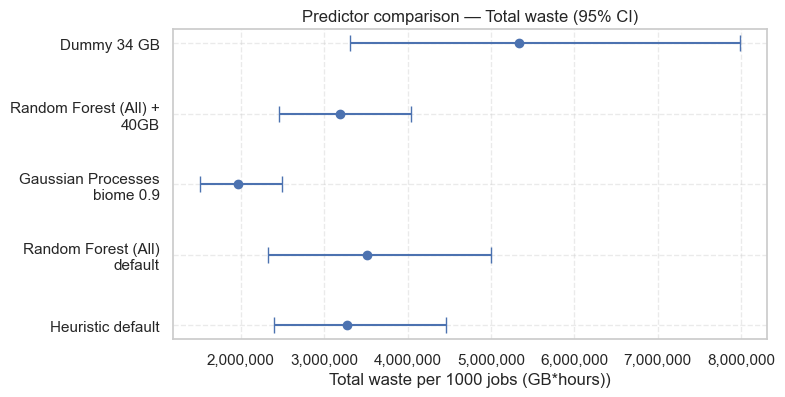

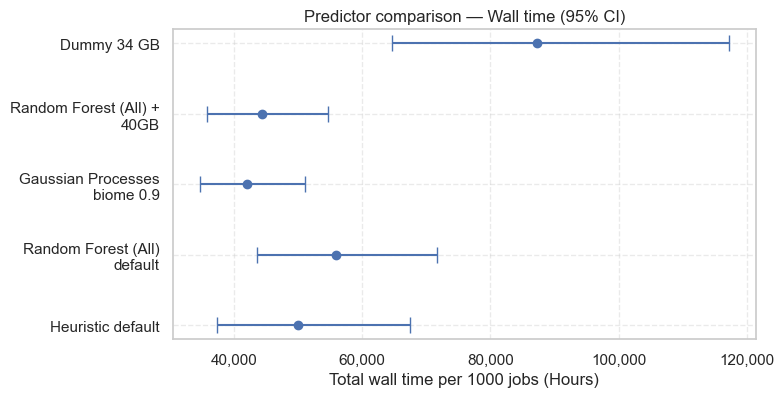

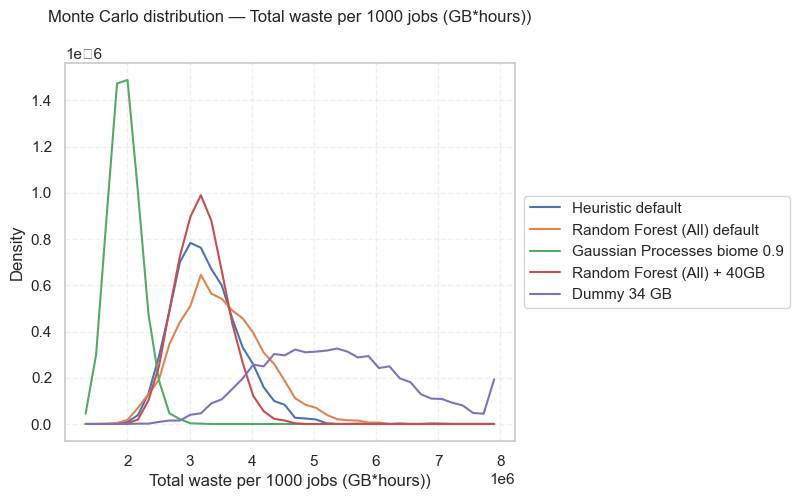

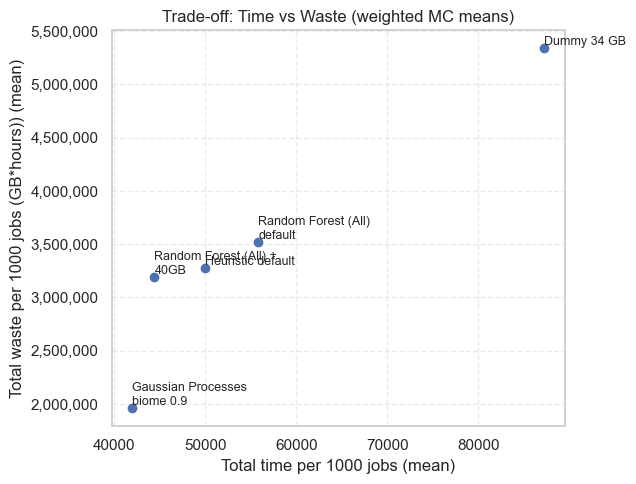

In [62]:

# Optional plots (require matplotlib)
ev.plot_errorbars(metric="waste")
ev.plot_errorbars(metric="wall")
# ev.plot_weighted_density(metric="waste", bins=50)
ev.plot_mc_distribution(metric="waste", bins=40)
ev.plot_tradeoff()


Despite its strong MAE and R², the Random Forest model did not outperform the current heuristic in total waste.

However, integrating biome as feature (Gaussian Processes) showed promising results.

---

## What this means for us

If we continue to rely on traditional metrics, we risk selecting models that look good in tests but cost more in production.

Model evaluation must account for how jobs are distributed and how systems recover from errors.

By incorporating real workload distributions, memory-time usage, and retry costs, we can design metrics that reward what truly matters: fewer failures and lower total waste.

Message to take away: Re-evaluate model selection under these realistic conditions.

## Next steps

- Collect more real job data to better represent actual workloads.
- Include failed job logs to improve model training.
- Define and test cost-aware evaluation metrics that combine accuracy, retry behavior, and operational efficiency. This could also help with training loss functions.
- Explore adaptive allocation strategies that adjust based on past job performance.
- Better metrics mean better models — and better use of HPC systems.